author: Diogo Silva

SKL = SciKit-Learn

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [82]:
import seaborn as sbn

In [4]:
home = %env HOME

In [5]:
cd $home/QCThesis/EAC

/home/chiroptera/workspace/QCThesis/EAC


In [39]:
from sklearn.cluster import KMeans as KMeans_skl
import eac
reload(eac)
import K_Means3
reload(K_Means3)
import determine_ci
reload(determine_ci)

<module 'determine_ci' from 'determine_ci.pyc'>

# Helper functions

In [219]:
def stat_my_kmeans(data,nclusters,gtruth,rounds=20):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        grouper = K_Means3.K_Means()
        grouper._centroid_mode = "index"
        grouper.fit(data, nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,grouper.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)
    
def stat_skl_kmeans(data,nclusters,gtruth,rounds=20,init='random'):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        gSKL = KMeans_skl(n_clusters=nclusters,n_init=1,init=init)
        gSKL.fit(data)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,gSKL.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

In [211]:
def k_analysis(partition_files,ground_truth,nprots,iters="converge",rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]

        grouper = K_Means3.K_Means()
        grouper._centroid_mode = "index"
        grouper.fit(estimator._coassoc, nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(ground_truth,grouper.labels_,format='array')
        all_acc.append(accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

def k_skl_analysis(partition_files,ground_truth,nprots,rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]


        grouper = KMeans_skl(n_clusters=nclusters,n_init=1,init="random")
        grouper.fit(estimator._coassoc)
        
        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(ground_truth,grouper.labels_,format='array')
        all_acc.append(accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

# Generate data

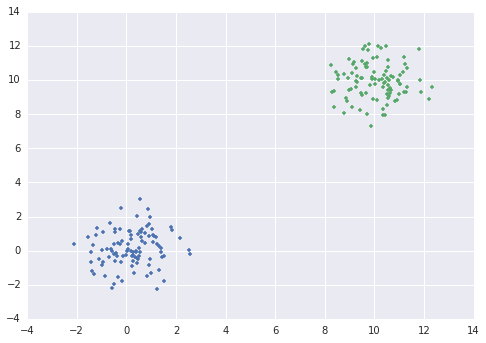

In [86]:
center1=(0,0)
center2=(10,10)

cov1=1
cov2=1

n1=100
n2=100
nsamples=n1+n2
dim=2

g1 = np.random.normal(loc=center1,scale=cov1,size=(n1,dim))
g2 = np.random.normal(loc=center2,scale=cov2,size=(n2,dim))

data = np.vstack((g1,g2))
gt=np.zeros(data.shape[0],dtype=np.int32)
gt[100:]=1

figData=plt.figure()
plt.plot(g1[:,0],g1[:,1],'.')
plt.plot(g2[:,0],g2[:,1],'.')

# EAC

In [15]:
def formatPartition(partition):
    nclusters=np.unique(partition).shape[0]
    finalPartition=[list() for x in xrange(nclusters)]
    for n,c in partition:
        finalPartition[c].append(n)
        
    return finalPartition

def generatePartitions(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list():
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        grouper = K_Means3.K_Means()
        grouper._centroid_mode = "index"
        grouper.fit(data, k, iters=iters, mode=mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        partitions.append(grouper.partition)
        
    return partitions
        
def generatePartitionsSKL(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list():
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        gSKL = KMeans_skl(n_clusters=k,n_init=1,init="random",max_iter=iters)
        gSKL.fit(data)
        partitions.append(formatPartition(gSKL.labels_))
        
    return partitions
    

## Partitions with 10 clusters

In [366]:
npartitions=30
nclusters=10
iters=3

partitions_my = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

allGood=True
for p in xrange(npartitions):
    if len(partitions_my[p]) != nclusters:
        print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my[p]))
        allGood=False
    if len(partitions_skl[p]) != nclusters:
        print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl[p]))
        allGood=False
if allGood:
    print 'All partitions have good number of clusters.'

All partitions have good number of clusters.


### Visualizing some partitions

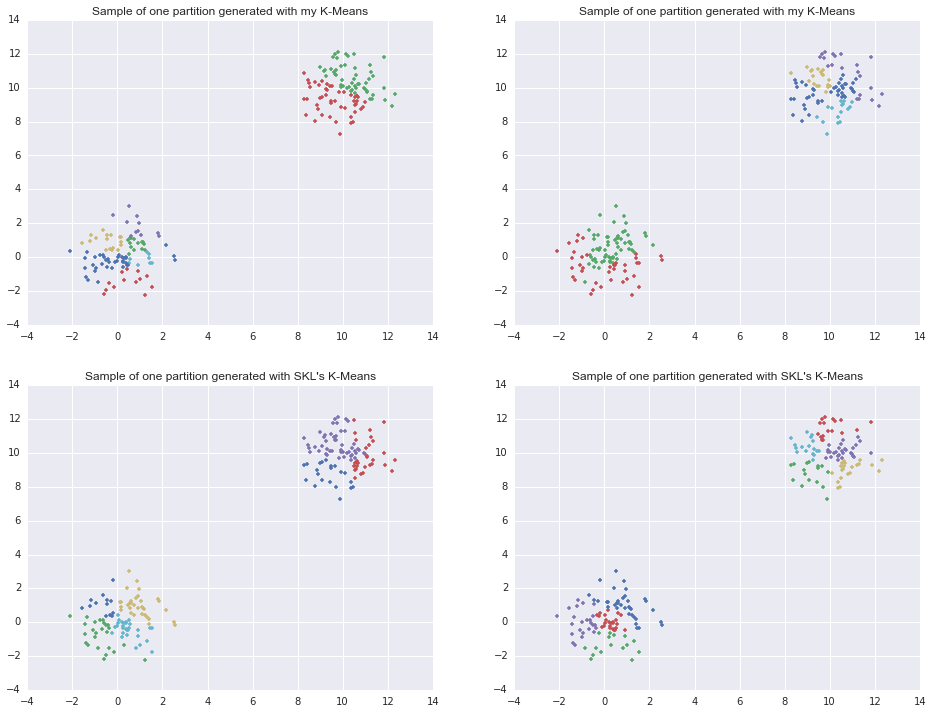

In [367]:
figEnsemble=plt.figure(figsize=(16,12))
ax1En=figEnsemble.add_subplot(2,2,1)
ax2En=figEnsemble.add_subplot(2,2,2)
ax3En=figEnsemble.add_subplot(2,2,3)
ax4En=figEnsemble.add_subplot(2,2,4)

for c in partitions_my[0]:
    ax1En.plot(data[c,0],data[c,1],'.')
ax1En.set_title("Sample of one partition generated with my K-Means")

for c in partitions_my[1]:
    ax2En.plot(data[c,0],data[c,1],'.')
ax2En.set_title("Sample of one partition generated with my K-Means")

for c in partitions_skl[0]:
    ax3En.plot(data[c,0],data[c,1],'.')
ax3En.set_title("Sample of one partition generated with SKL's K-Means")

for c in partitions_skl[1]:
    ax4En.plot(data[c,0],data[c,1],'.')
ax4En.set_title("Sample of one partition generated with SKL's K-Means")

## Clustering

My Accuracy:	1.0
SKL Accuracy:	1.0


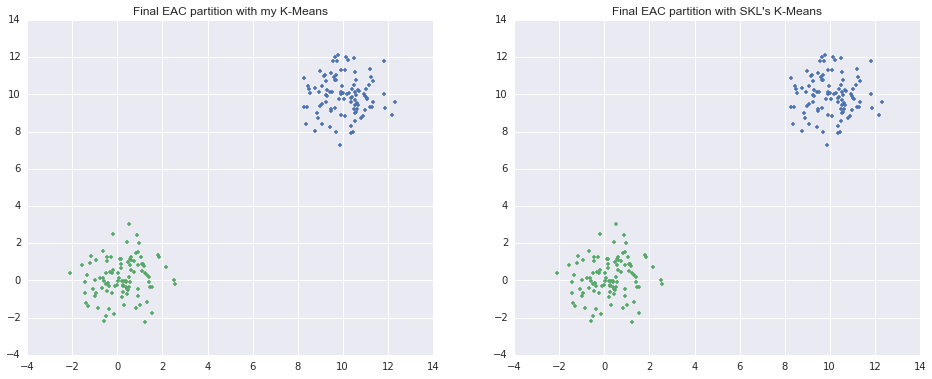

In [368]:
# generate coassoc
prot_mode="random"
assoc_mode='prot' # prot or full
nprots=nsamples # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_my,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

sklEstimator=eac.EAC(nsamples)
sklEstimator.fit(partitions_skl,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means()
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc, true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(sklEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianAccuracy(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianAccuracy(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC=plt.figure(figsize=(16,6))
ax1EAC=figEAC.add_subplot(1,2,1)
ax2EAC=figEAC.add_subplot(1,2,2)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC.set_title("Final EAC partition with SKL's K-Means")

Accuracy is usually 100% in both cases (clustering from my K-Means and SciKit-Learn's). This depends on the ensemble. For some ensembles the accuracy on both is always one, for others it sometimes is not in one or both of the K-Means used (mine vs SKL).

The number of prototypes is equal to the number of samples and since there are not repeated prototypes, all the samples are being used. Above are the visualizations of the solutions. 

In [369]:
print "My coassoc"
print myEstimator._coassoc
print "\nSKL coassoc"
print sklEstimator._coassoc

My coassoc
[[  0.   0.   4. ...,  28.  25.   0.]
 [  0.   0.  21. ...,   4.   3.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 11.   5.   0. ...,   0.   0.   8.]
 [  2.  18.   0. ...,   0.   0.  25.]
 [  2.   1.   0. ...,   0.   0.   3.]]

SKL coassoc
[[  0.   2.   0. ...,   0.   0.   3.]
 [  0.  14.   0. ...,   2.   0.   4.]
 [  0.   0.   0. ...,  19.   0.   8.]
 ..., 
 [  6.   0.   1. ...,   0.  24.   0.]
 [ 30.   0.  11. ...,   0.   6.   0.]
 [  2.   0.   1. ...,   0.  19.   0.]]


## Statistic analysis

In [370]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "my  \t",
for metric in k_analysis(partitions_my,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),
print "\nskl \t",
for metric in k_skl_analysis(partitions_skl,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),

type	mean	var	max	min
my  	0.9604	0.00714384	1.0	0.78	
skl 	0.9547	0.01027341	1.0	0.7	

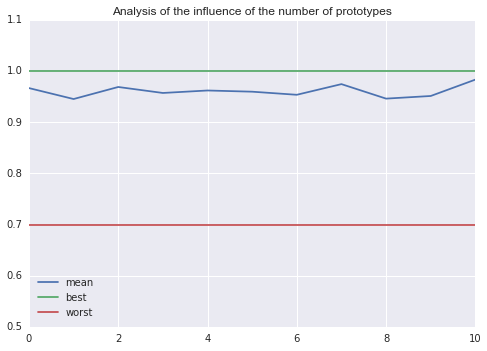

In [371]:
nprots=[5,20,40,60,80,100,120,140,160,180,200]
results_k10=list()
for n in nprots:
    r=k_skl_analysis(partitions_skl,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100)
    results_k10.append(r)
    
mean_k10=[res[0] for res in results_k10]
var_k10=[res[1] for res in results_k10]
best_k10=[res[2] for res in results_k10]
worst_k10=[res[3] for res in results_k10]

plt.plot(mean_k10,label='mean')
plt.plot(best_k10,label='best')
plt.plot(worst_k10,label='worst')
plt.plot([0, 10], [0.5, 0.5], 'k-', lw=1)
plt.title("Analysis of the influence of the number of prototypes")
plt.legend(loc='best')

## 6 clusters per partition

All partitions have good number of clusters.
My Accuracy:	1.0
SKL Accuracy:	1.0

Statistical analysis
type	mean	var	max	min
skl 	1.0	0.0	1.0	1.0	
my  	1.0	0.0	1.0	1.0	

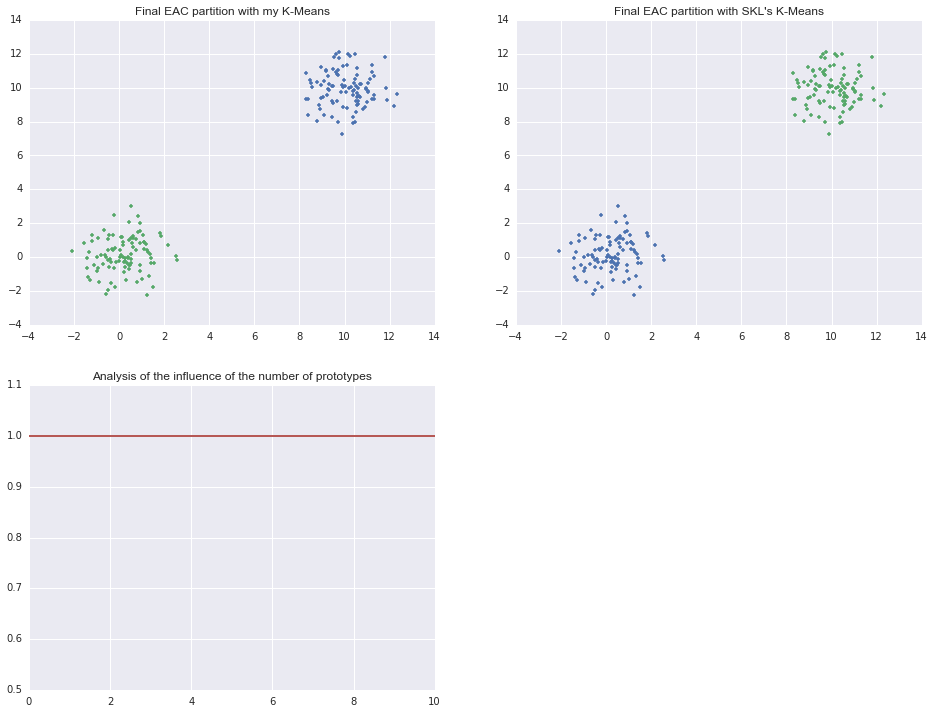

In [365]:
npartitions=30
nclusters=6
iters=3

partitions_my = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

allGood=True
for p in xrange(npartitions):
    if len(partitions_my[p]) != nclusters:
        print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my[p]))
        allGood=False
    if len(partitions_skl[p]) != nclusters:
        print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl[p]))
        allGood=False
if allGood:
    print 'All partitions have good number of clusters.'
    

# generate coassoc
prot_mode="random"
assoc_mode='prot' # prot or full
nprots=nsamples # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_my,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

sklEstimator=eac.EAC(nsamples)
sklEstimator.fit(partitions_skl,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means()
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc, true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(sklEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianAccuracy(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianAccuracy(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC2=plt.figure(figsize=(16,12))
ax1EAC2=figEAC2.add_subplot(2,2,1)
ax2EAC2=figEAC2.add_subplot(2,2,2)
ax3EAC2=figEAC2.add_subplot(2,2,3)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC2.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC2.set_title("Final EAC partition with SKL's K-Means")

nprots=[5,20,40,60,80,100,120,140,160,180,200]
results_k6=list()
for n in nprots:
    r=k_skl_analysis(partitions_skl,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100)
    results_k6.append(r)
    
mean_k6=[res[0] for res in results_k6]
var_k6=[res[1] for res in results_k6]
best_k6=[res[2] for res in results_k6]
worst_k6=[res[3] for res in results_k6]

ax3EAC2.plot(mean_k10)
ax3EAC2.plot(best_k10)
ax3EAC2.plot(worst_k10)
ax3EAC2.plot([0, 10], [0.5, 0.5], 'k-', lw=1)
ax3EAC2.set_title("Analysis of the influence of the number of prototypes")

print "\nStatistical analysis"
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "skl \t",
for metric in k_skl_analysis(partitions_my,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),
print "\nmy  \t",
for metric in k_analysis(partitions_my,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),

# K-Means only

In [342]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "my  \t",
for metric in stat_my_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),
print "\nskl \t",
for metric in stat_skl_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),

type	mean	var	max	min
my  	1.0	0.0	1.0	1.0	
skl 	1.0	0.0	1.0	1.0	